In [8]:
# pip install --quiet harmonypy

You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# pip install --quiet git+https://github.com/theislab/scgen.git

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import harmonypy as hm

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

# Import the data

In [3]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/macaque_public/macaque_public.h5ad")
adata = anndata.read_h5ad("../macaque_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 30302 × 36162
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH'
    var: 'gene_name'

In [4]:
adata.obs['batch'] = adata.obs['sample'].values

In [5]:
embeddings_dict = {}

In [6]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Setting: mixing and missing at the edge

#### If you want to train the Harmony again

In [ ]:
# Step 1: Run Harmony integration
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use
vars_use = ['batch']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T

2024-12-16 16:53:30,499 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-12-16 16:53:45,257 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-12-16 16:53:45,551 - harmonypy - INFO - Iteration 1 of 10
2024-12-16 16:54:01,819 - harmonypy - INFO - Iteration 2 of 10
2024-12-16 16:54:13,296 - harmonypy - INFO - Iteration 3 of 10
2024-12-16 16:54:30,171 - harmonypy - INFO - Iteration 4 of 10
2024-12-16 16:54:44,622 - harmonypy - INFO - Converged after 4 iterations


Training completed in 74.16 seconds


In [ ]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

In [ ]:
# Step 2: Perform KNN on the integrated data
sc.pp.neighbors(adata, use_rep="X_harmony", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)

#### Utilize the Harmony results before in unsupervised learning

In [7]:
import pandas as pd

# Step 1: Load the saved embeddings CSV file
full_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_macaque.csv", index_col=0)

# Step 2: Ensure indices match the adata object
full_embeddings = full_embeddings.loc[adata.obs_names]

# Step 3: Extract the X_harmony embeddings
X_harmony = full_embeddings.filter(like="X_harmony")

# Step 4: Assign the embeddings back to adata.obsm
adata.obsm["X_harmony"] = X_harmony.values

# Step 5: Perform KNN and UMAP using X_harmony
sc.pp.neighbors(adata, use_rep="X_harmony", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)

In [8]:
def reassign_edge_cells_with_unknown(adata, n_neighbors=30, threshold=0.3, random_seed=42):
    # Set the random seed for reproducibility
    np.random.seed(random_seed)
    
    # Fit nearest neighbors on the 'X_harmony' embedding
    neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(adata.obsm['X_harmony'])
    distances, indices = neighbors.kneighbors(adata.obsm['X_harmony'])

    true_labels = adata.obs['cell_type'].copy()

    # If true_labels is categorical, add "unknown" to its categories
    if pd.api.types.is_categorical_dtype(true_labels):
        true_labels = true_labels.cat.add_categories(["Unknown"])

    new_labels = true_labels.copy()

    for i in range(len(true_labels)):
        neighbor_labels = true_labels.iloc[indices[i]]
        proportion_diff = (neighbor_labels != true_labels.iloc[i]).mean()

        if proportion_diff > threshold:
            # Sample a new label based on the proportion of neighboring cell types
            label_proportions = neighbor_labels.value_counts(normalize=True)
            new_label = np.random.choice(label_proportions.index, p=label_proportions.values)

            # If the new label is the same as the original, set it to "unknown"
            if new_label == true_labels.iloc[i]:
                new_labels.iloc[i] = "Unknown"
            else:
                new_labels.iloc[i] = new_label

    adata.obs['new_labels'] = new_labels

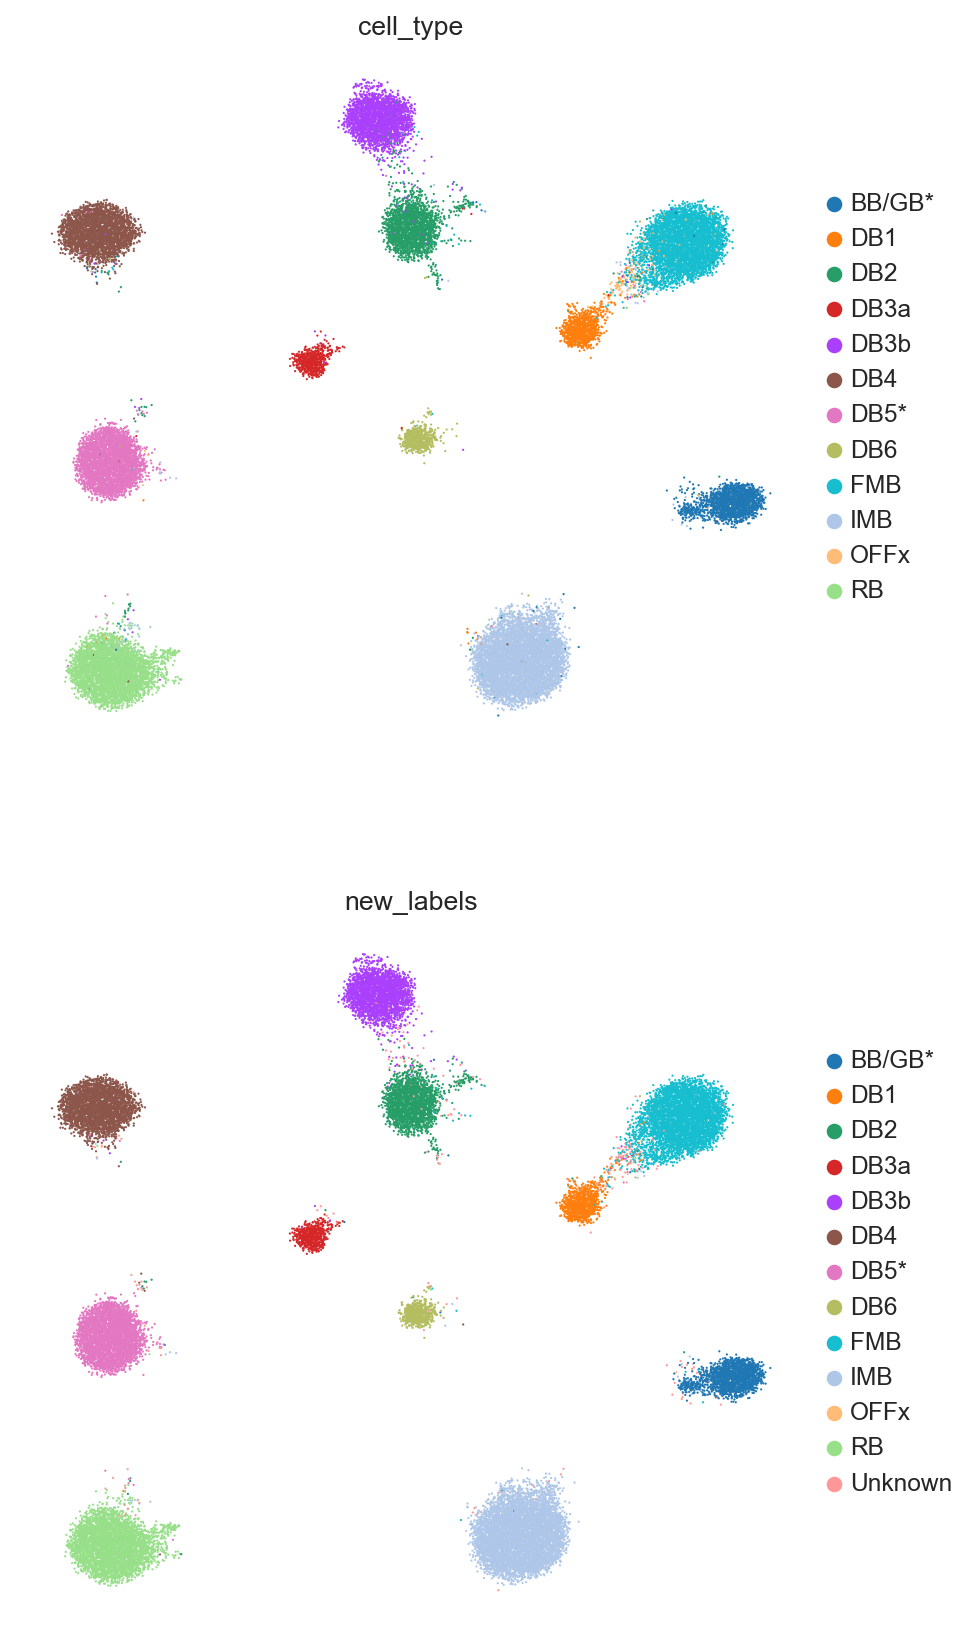

In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Apply the edge cell reassignment
reassign_edge_cells_with_unknown(adata, n_neighbors=30, threshold=0.3, random_seed=666)

# Verify results
sc.pl.umap(adata, color=['cell_type', 'new_labels'], ncols = 1)

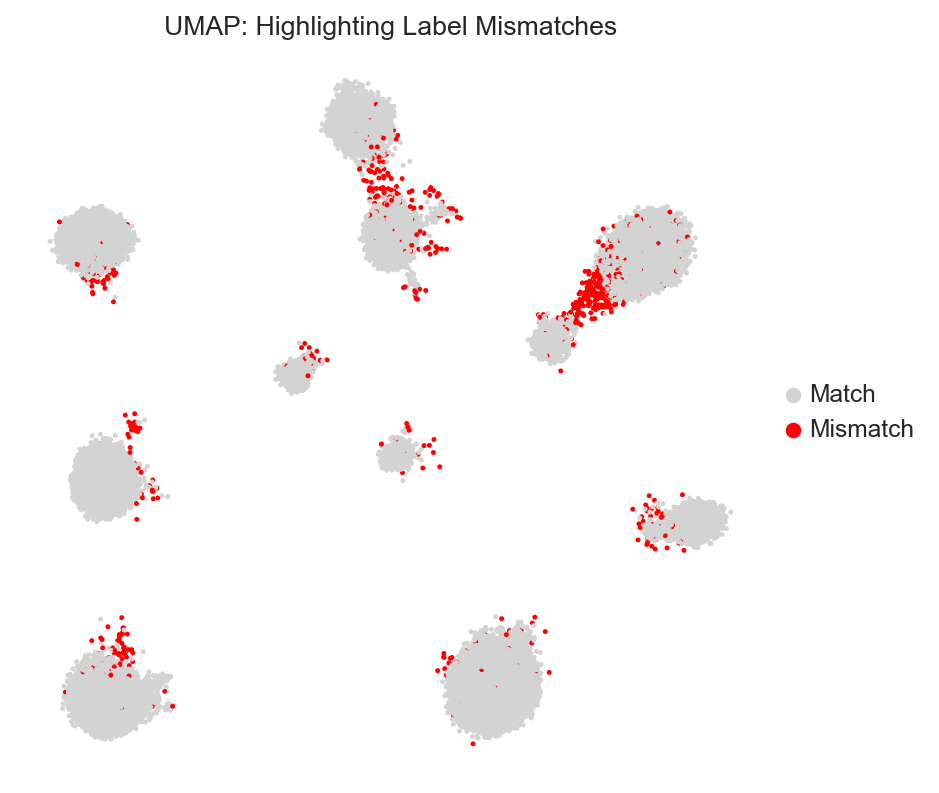

In [10]:
# Create a new column 'mismatch' indicating label differences
adata.obs['mismatch'] = np.where(
    adata.obs['new_labels'].astype(str) != adata.obs['cell_type'].astype(str),
    'Mismatch',
    'Match'
)

# Plot the UMAP with a custom palette: light gray for matching cells and red for mismatches
sc.pl.umap(
    adata, 
    color='mismatch', 
    palette=['lightgray', 'red'],
    title='UMAP: Highlighting Label Mismatches',
    size=20  # adjust point size as needed
)

In [11]:
def calculate_unknown_proportion(adata):
    unknown_count = (adata.obs['new_labels'] == "Unknown").sum()
    total_count = len(adata.obs['new_labels'])
    unknown_proportion = unknown_count / total_count
    return unknown_proportion

# Calculate the proportion of unknown cells
unknown_proportion = calculate_unknown_proportion(adata)
print(f"Proportion of unknown cells: {unknown_proportion:.2%}")

Proportion of unknown cells: 0.88%


In [12]:
# Convert both columns to string type and then compare
mismatch_count = (adata.obs['new_labels'].astype(str) != adata.obs['cell_type'].astype(str)).sum()

# Total number of rows
total_rows = len(adata.obs)

# Calculate the proportion of mismatches
proportion_mismatch = mismatch_count / total_rows

print("Mismatch Count:", mismatch_count)
print("Total Rows:", total_rows)
print(f"Proportion of mismatches: {proportion_mismatch:.4f}")


Mismatch Count: 805
Total Rows: 30302
Proportion of mismatches: 0.0266


In [12]:
adata.obs['celltype'] = adata.obs['new_labels'].values

In [13]:
# Write `adata.obs` to a CSV file named 'metadata.csv'
adata.obs.to_csv('../R_macaque/labels/missing_and_mixing_at_edge_macaque_30_obs.csv', index=True)

## Read the labels

In [6]:
# Read the CSV with the index
new_labels_df = pd.read_csv("../R_macaque/labels/missing_and_mixing_at_edge_macaque_30_obs.csv", index_col=0)

# Assign the 'new_labels' column back to adata.obs
adata.obs['new_labels'] = new_labels_df['new_labels']

# scANVI

In [ ]:
# scVI
adata = adata.copy()
# adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 30/246:  12%|█▏        | 29/246 [11:09<1:28:51, 24.57s/it, v_num=1, train_loss_step=3.61e+3, train_loss_epoch=3.94e+3]

In [ ]:
# Save the trained model to a specified path
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [25]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

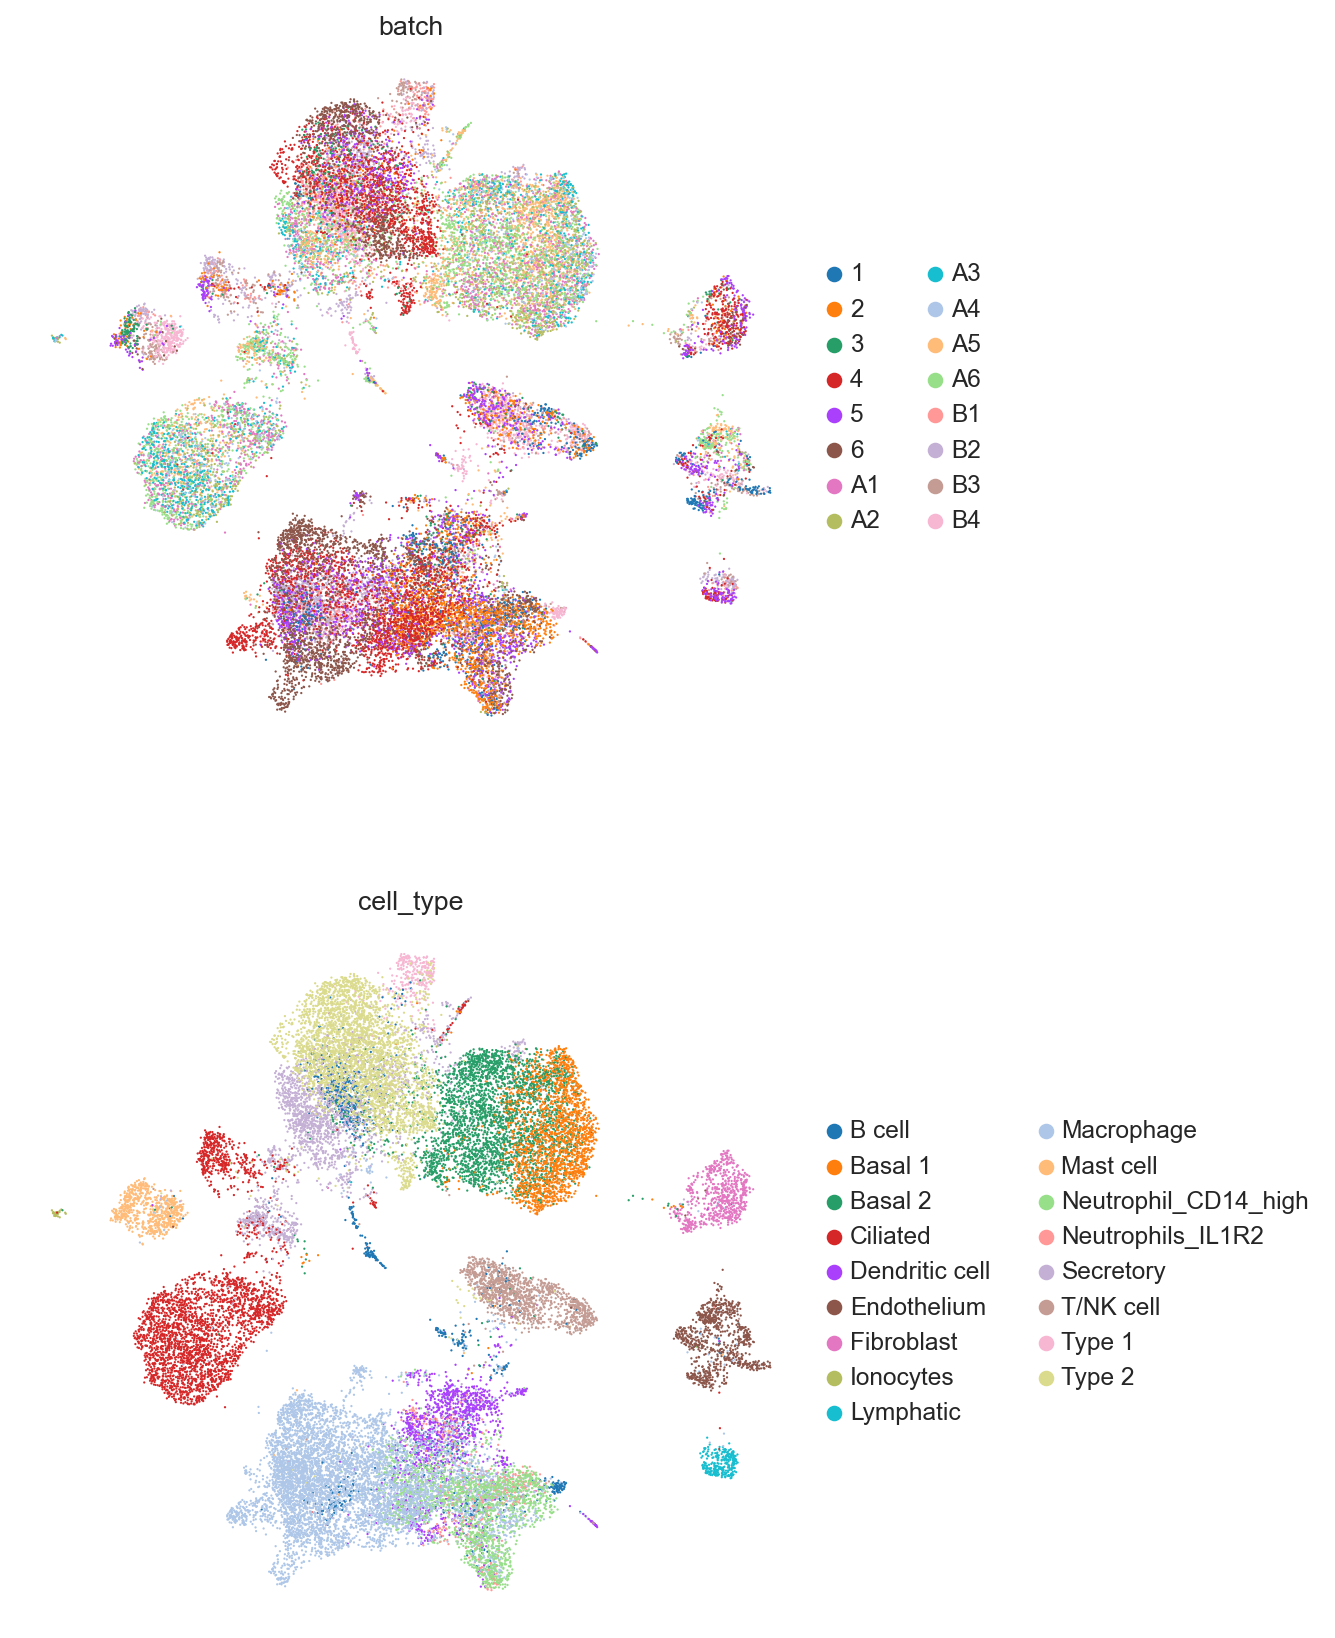

In [26]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [14]:
import scvi

# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [15]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="new_labels",
    unlabeled_category="Unknown",
)

In [16]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [18:11<00:00, 30.85s/it, v_num=1, train_loss_step=362, train_loss_epoch=383] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [18:11<00:00, 54.55s/it, v_num=1, train_loss_step=362, train_loss_epoch=383]


In [17]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [18]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [19]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

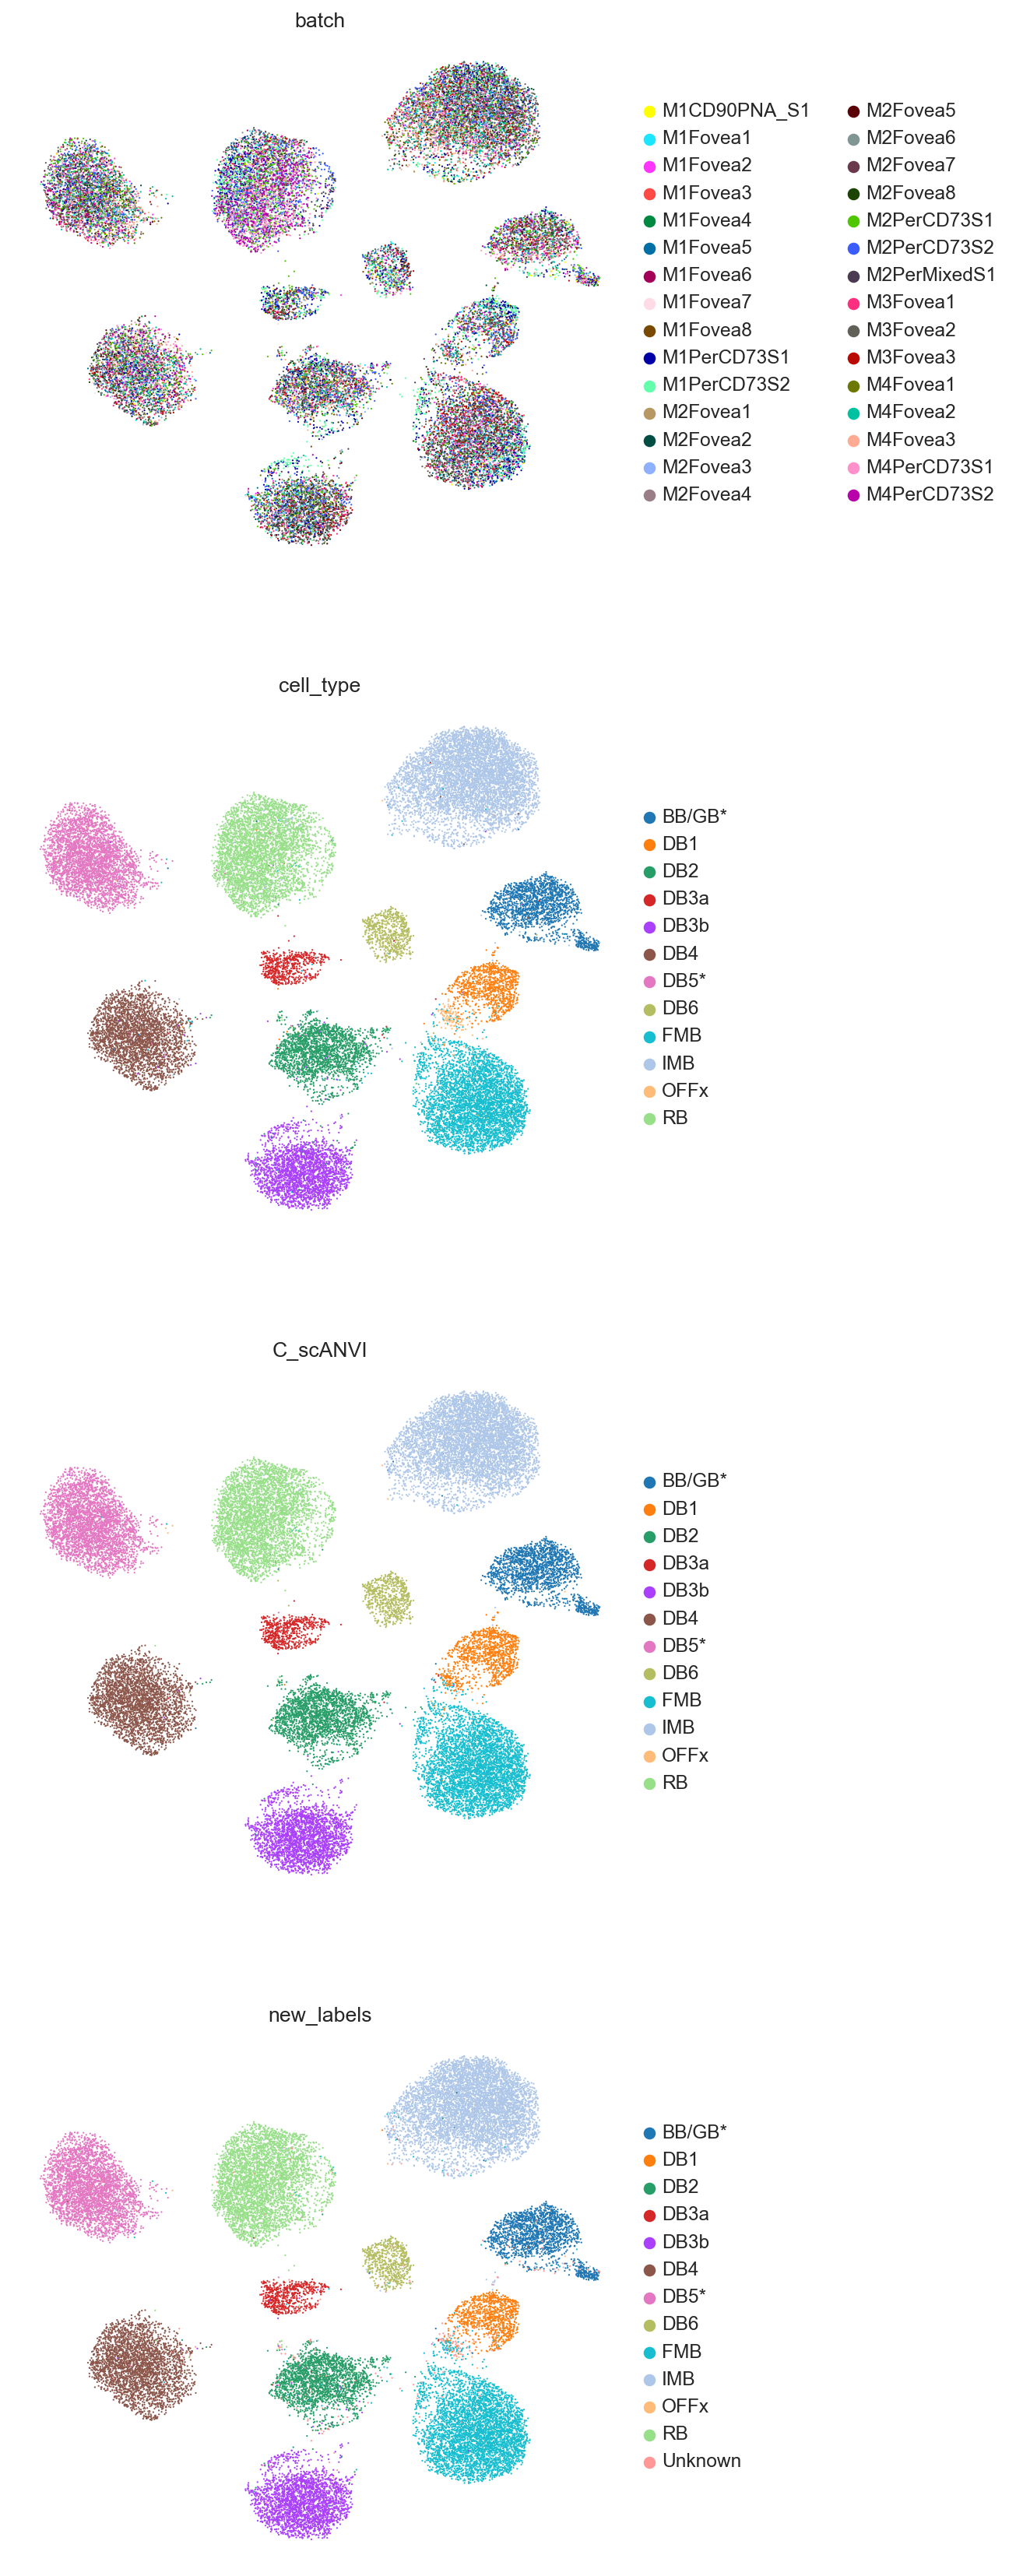

In [20]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI", "new_labels"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [21]:
train = adata.copy()

### Preprocessing Data

In [22]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="new_labels")

## Creating and Training the model¶

In [23]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|██▌       | 26/100 [31:33<1:29:50, 72.84s/it, v_num=1, train_loss_step=208, train_loss_epoch=178]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1033.173. Signaling Trainer to stop.


## Batch-Removal

In [24]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 30302 × 2000
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'cell_type', 'BATCH', 'n_genes', 'n_counts', 'new_labels', 'celltype', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [25]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [26]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

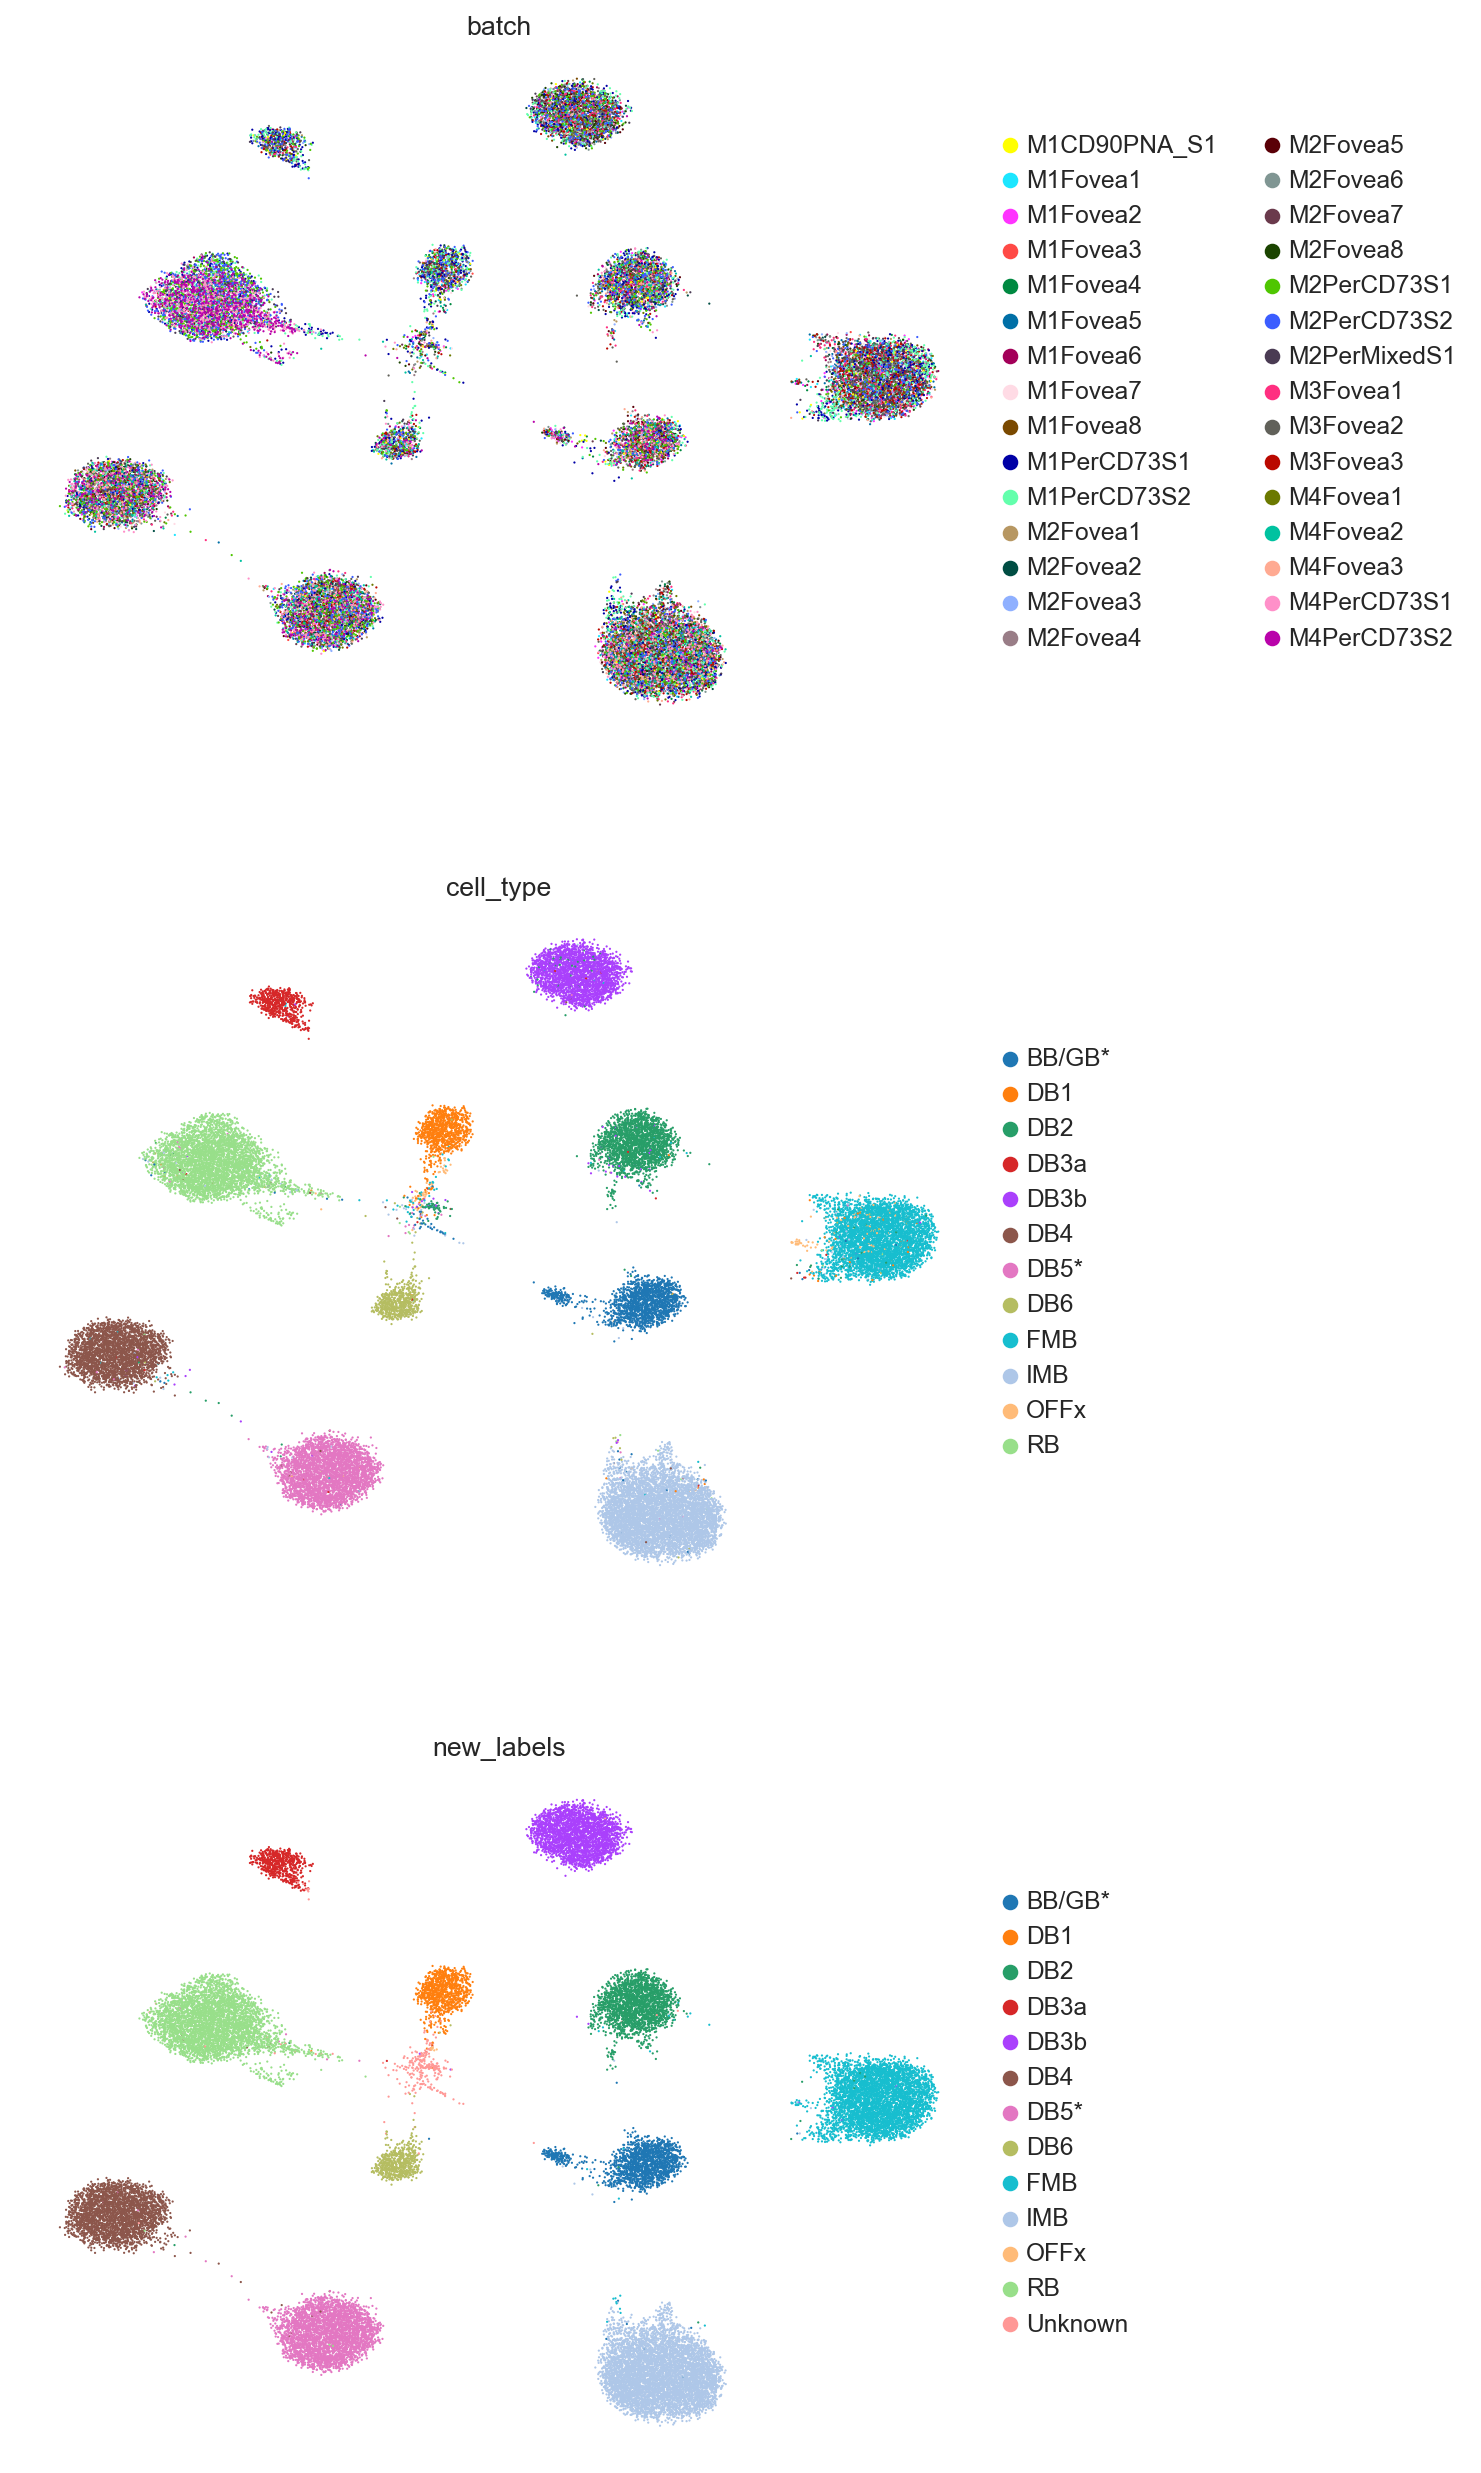

In [27]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', 'new_labels'], wspace=0.4, frameon=False, ncols=1)

# STACAS

Semi-supervised integration results

In [31]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/macaque_stacas_embeddings_missing_and_mixing_at_edge_30.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [32]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

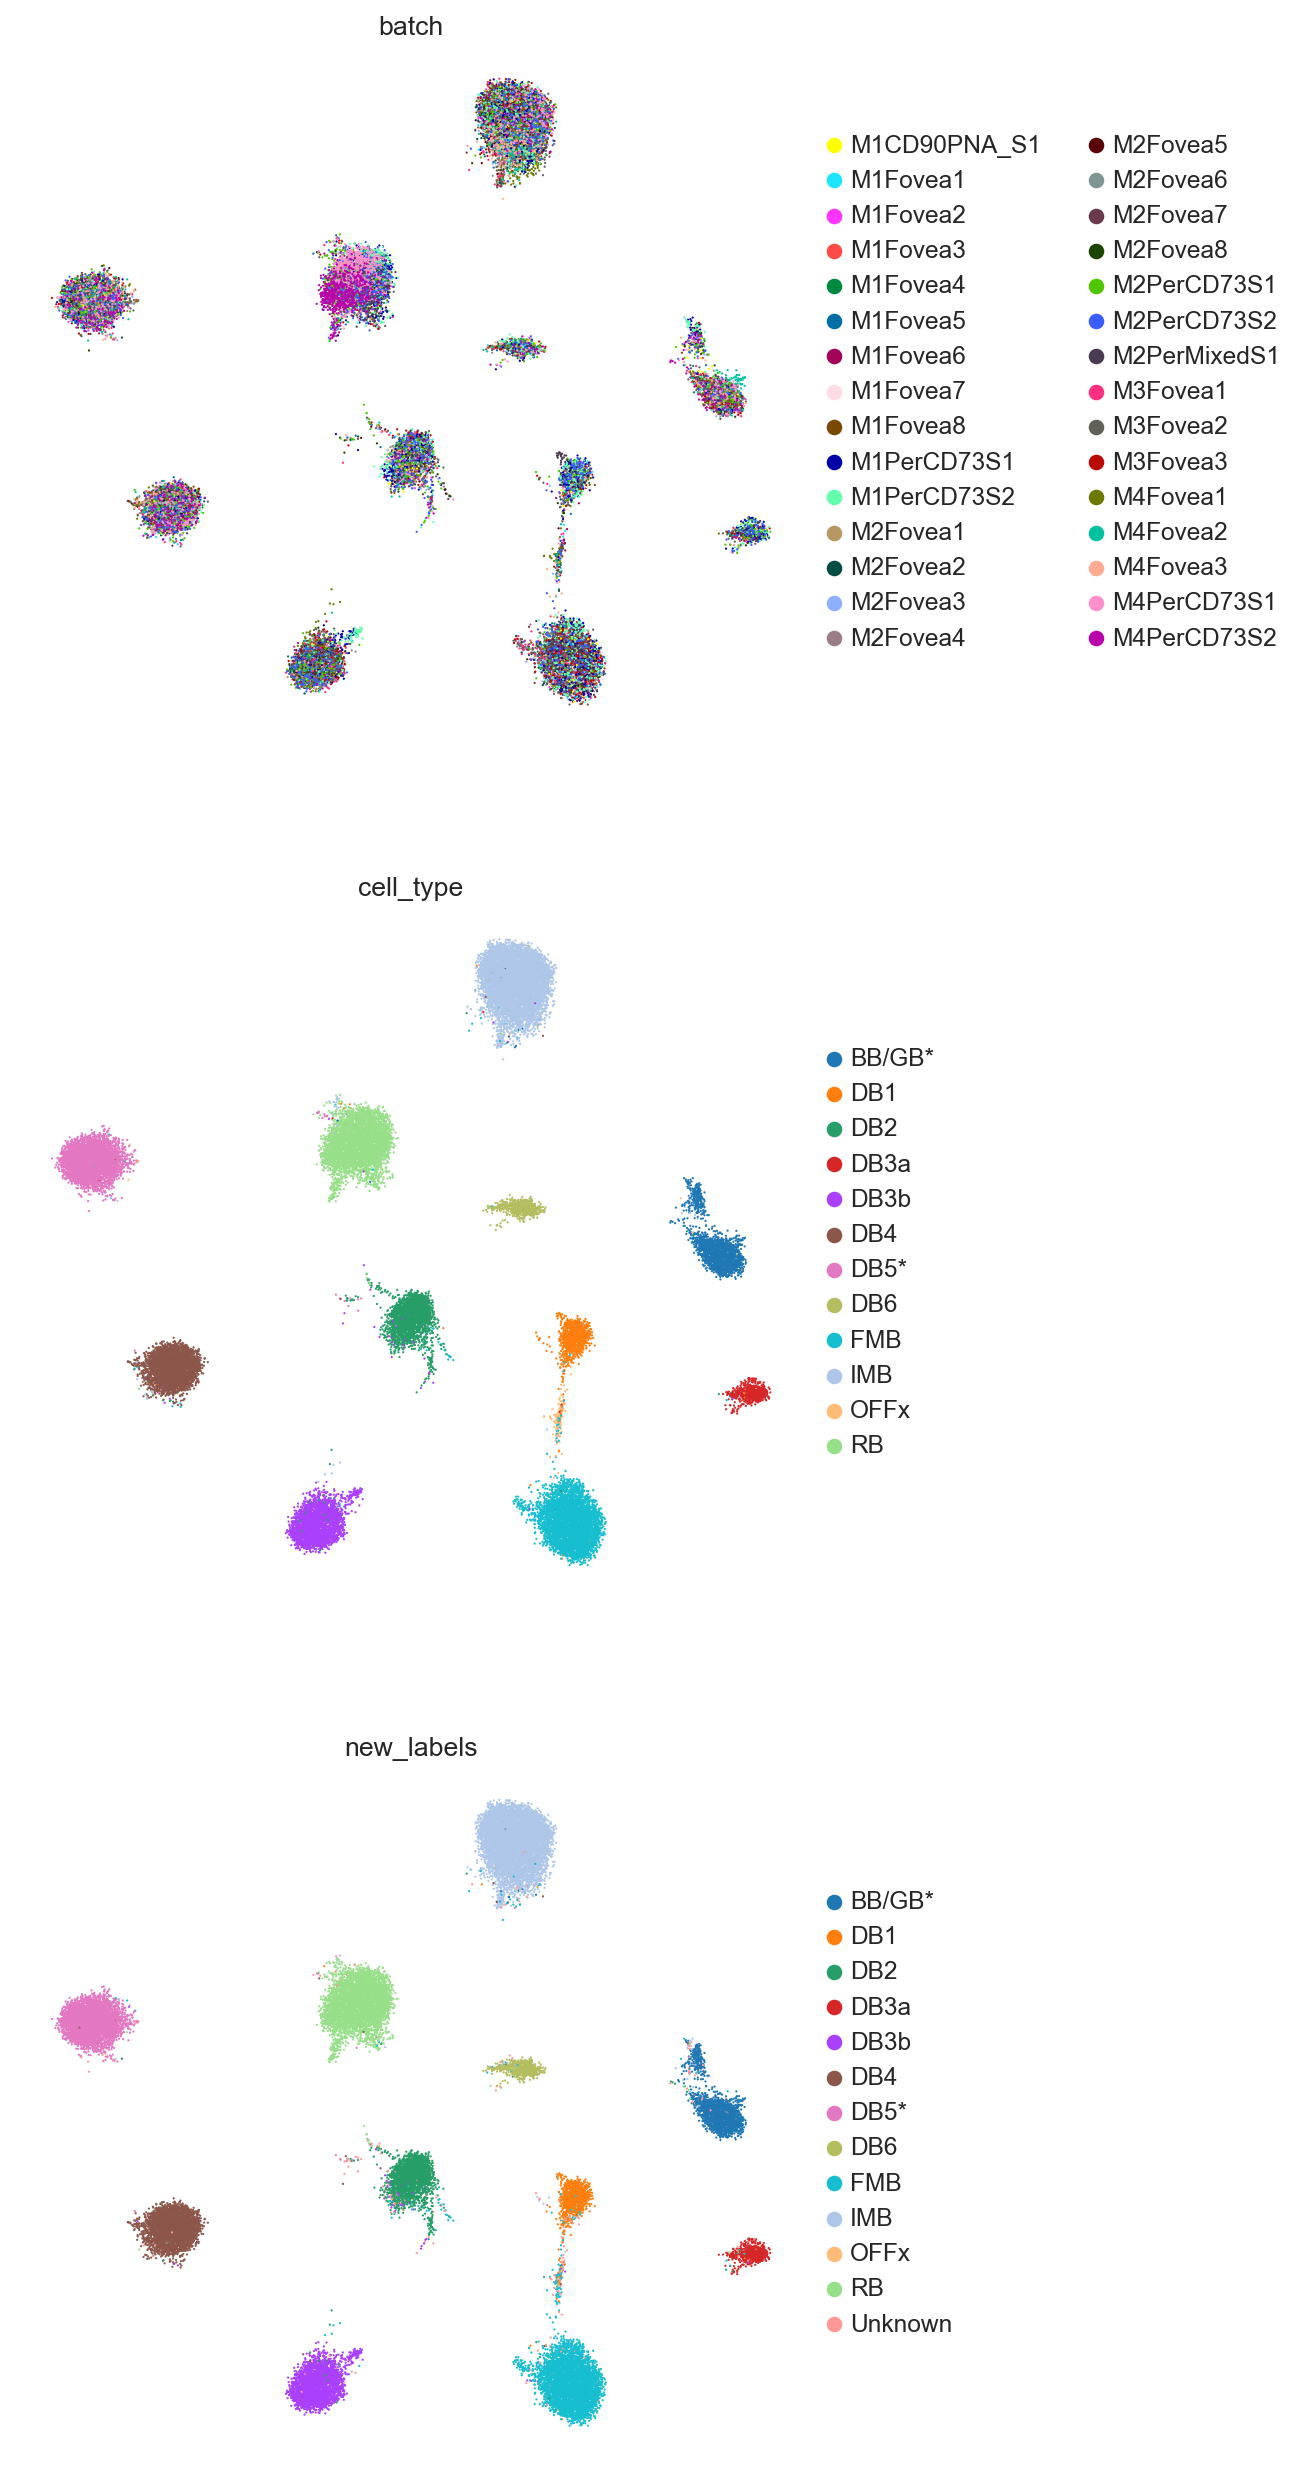

In [33]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

# scDREAMER

In [34]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/mixing_and_missing_at_edge_macaque_30_scdreamer_embeddings.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [35]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = pca_embeddings.values

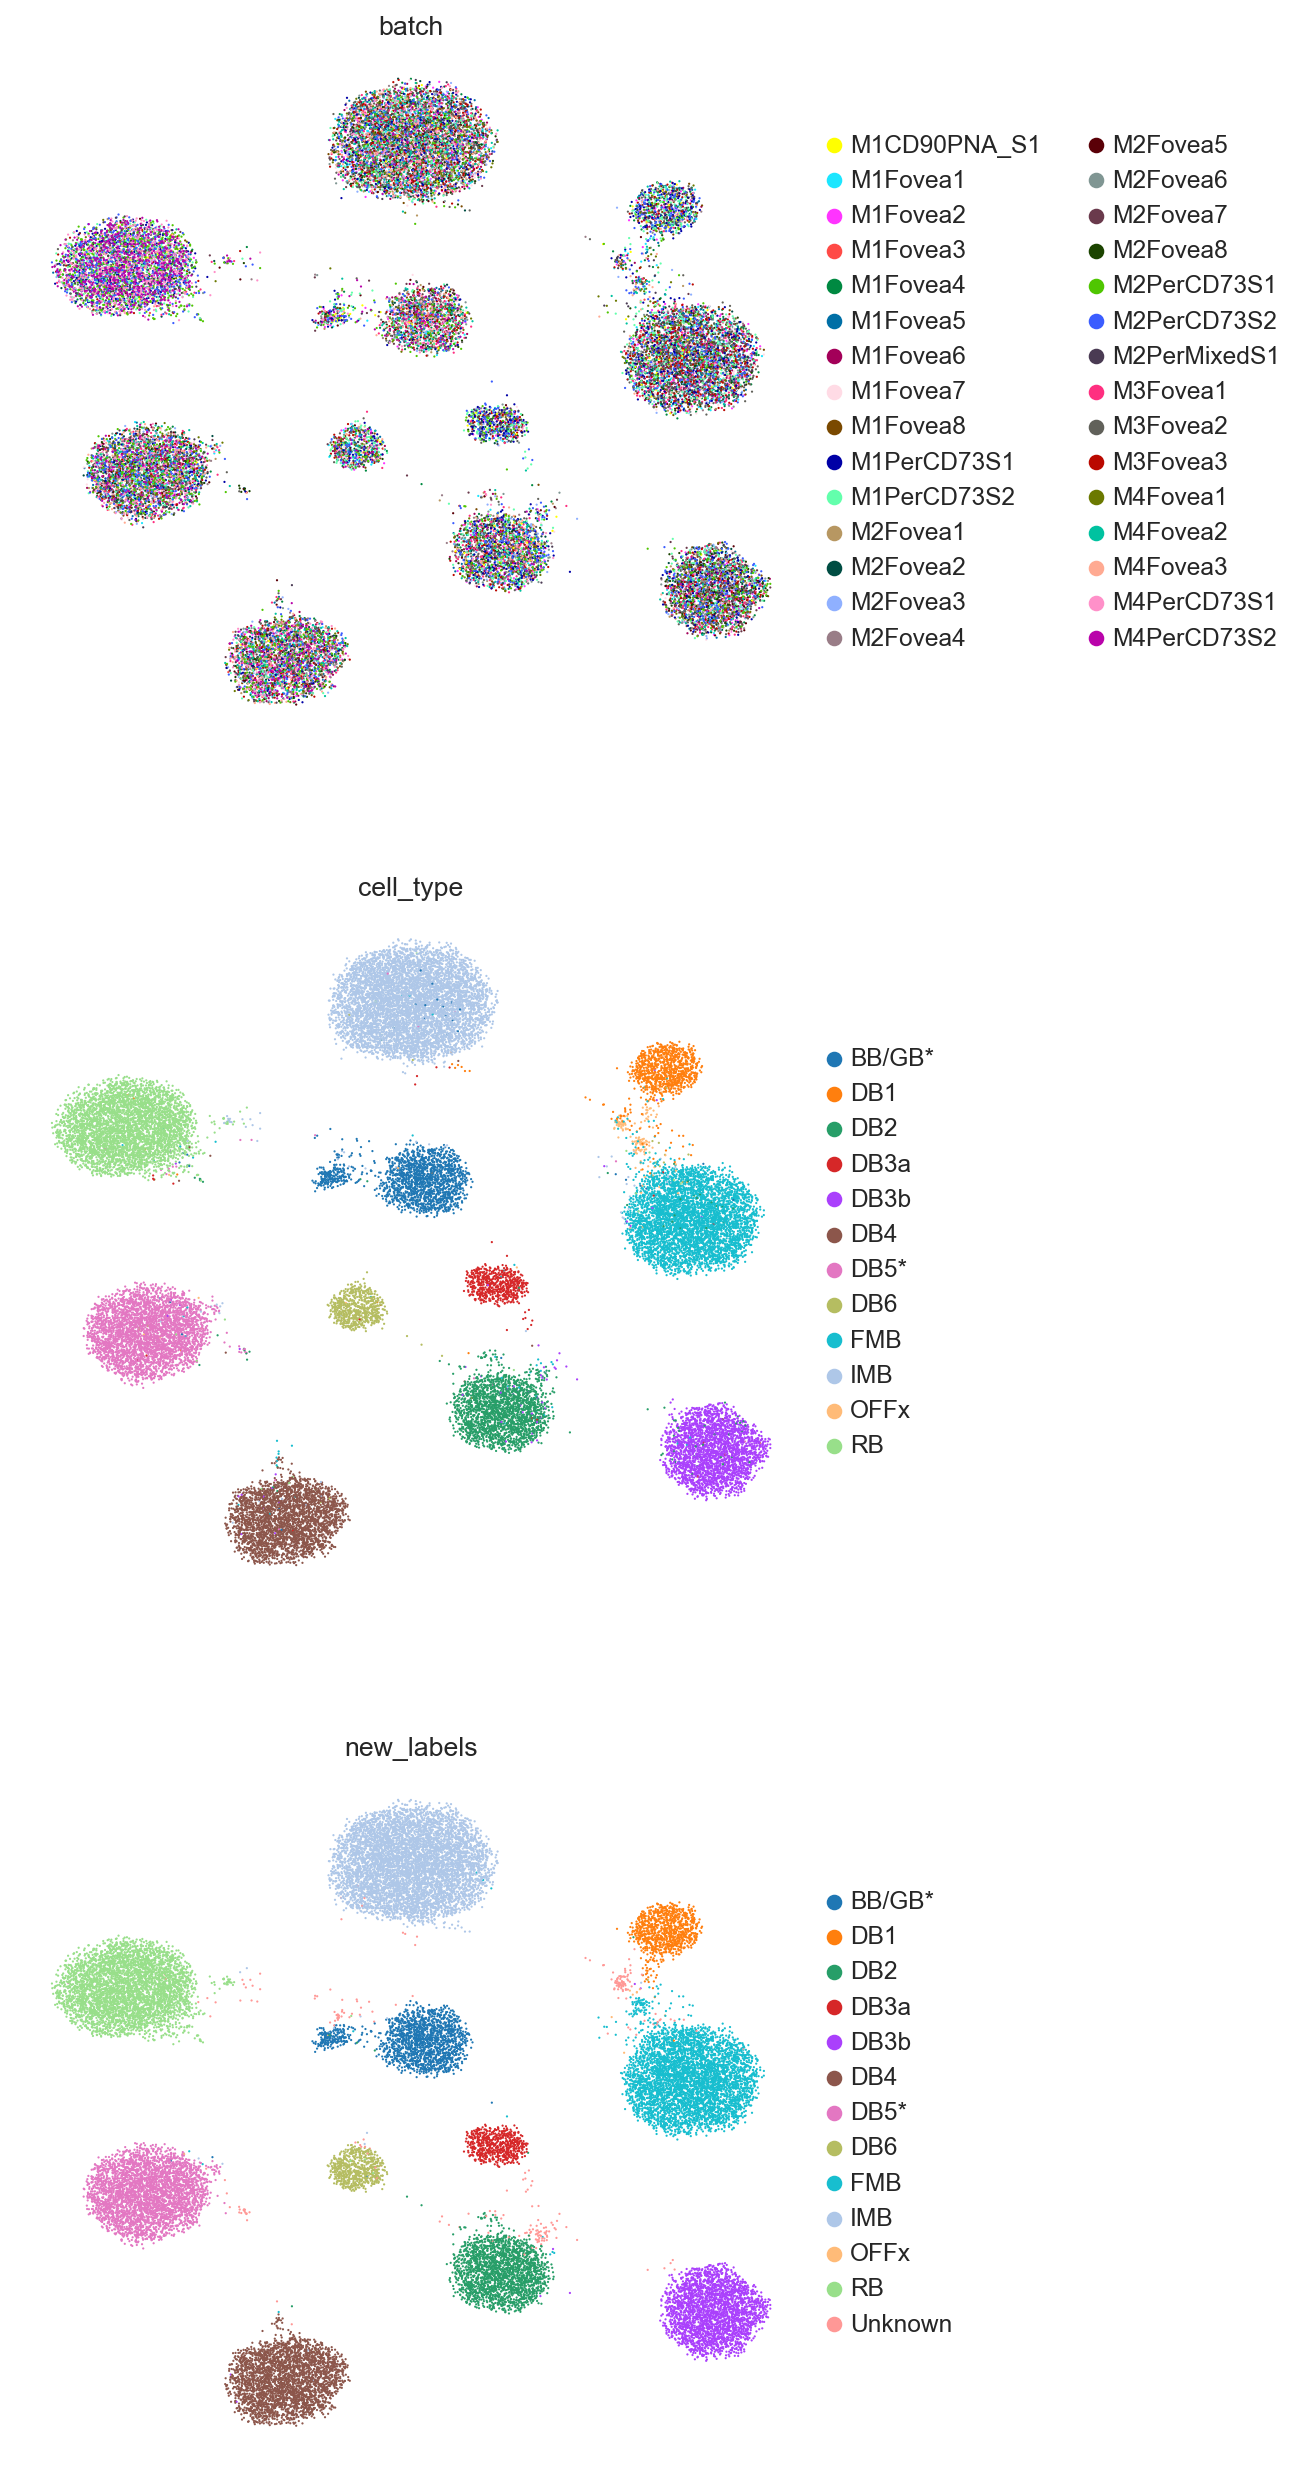

In [36]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

# ItClust

In [40]:
pca_embeddings = pd.read_csv('../R_macaque/embeddings/missing_and_mixing_at_edge_macaque_itclust_embeddings_30.csv', index_col=0)
adata.obsm['X_itclust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_itclust")
sc.tl.umap(adata, min_dist=0.5)

In [41]:
# Collect embeddings
embeddings_dict["X_itclust"] = pca_embeddings.values

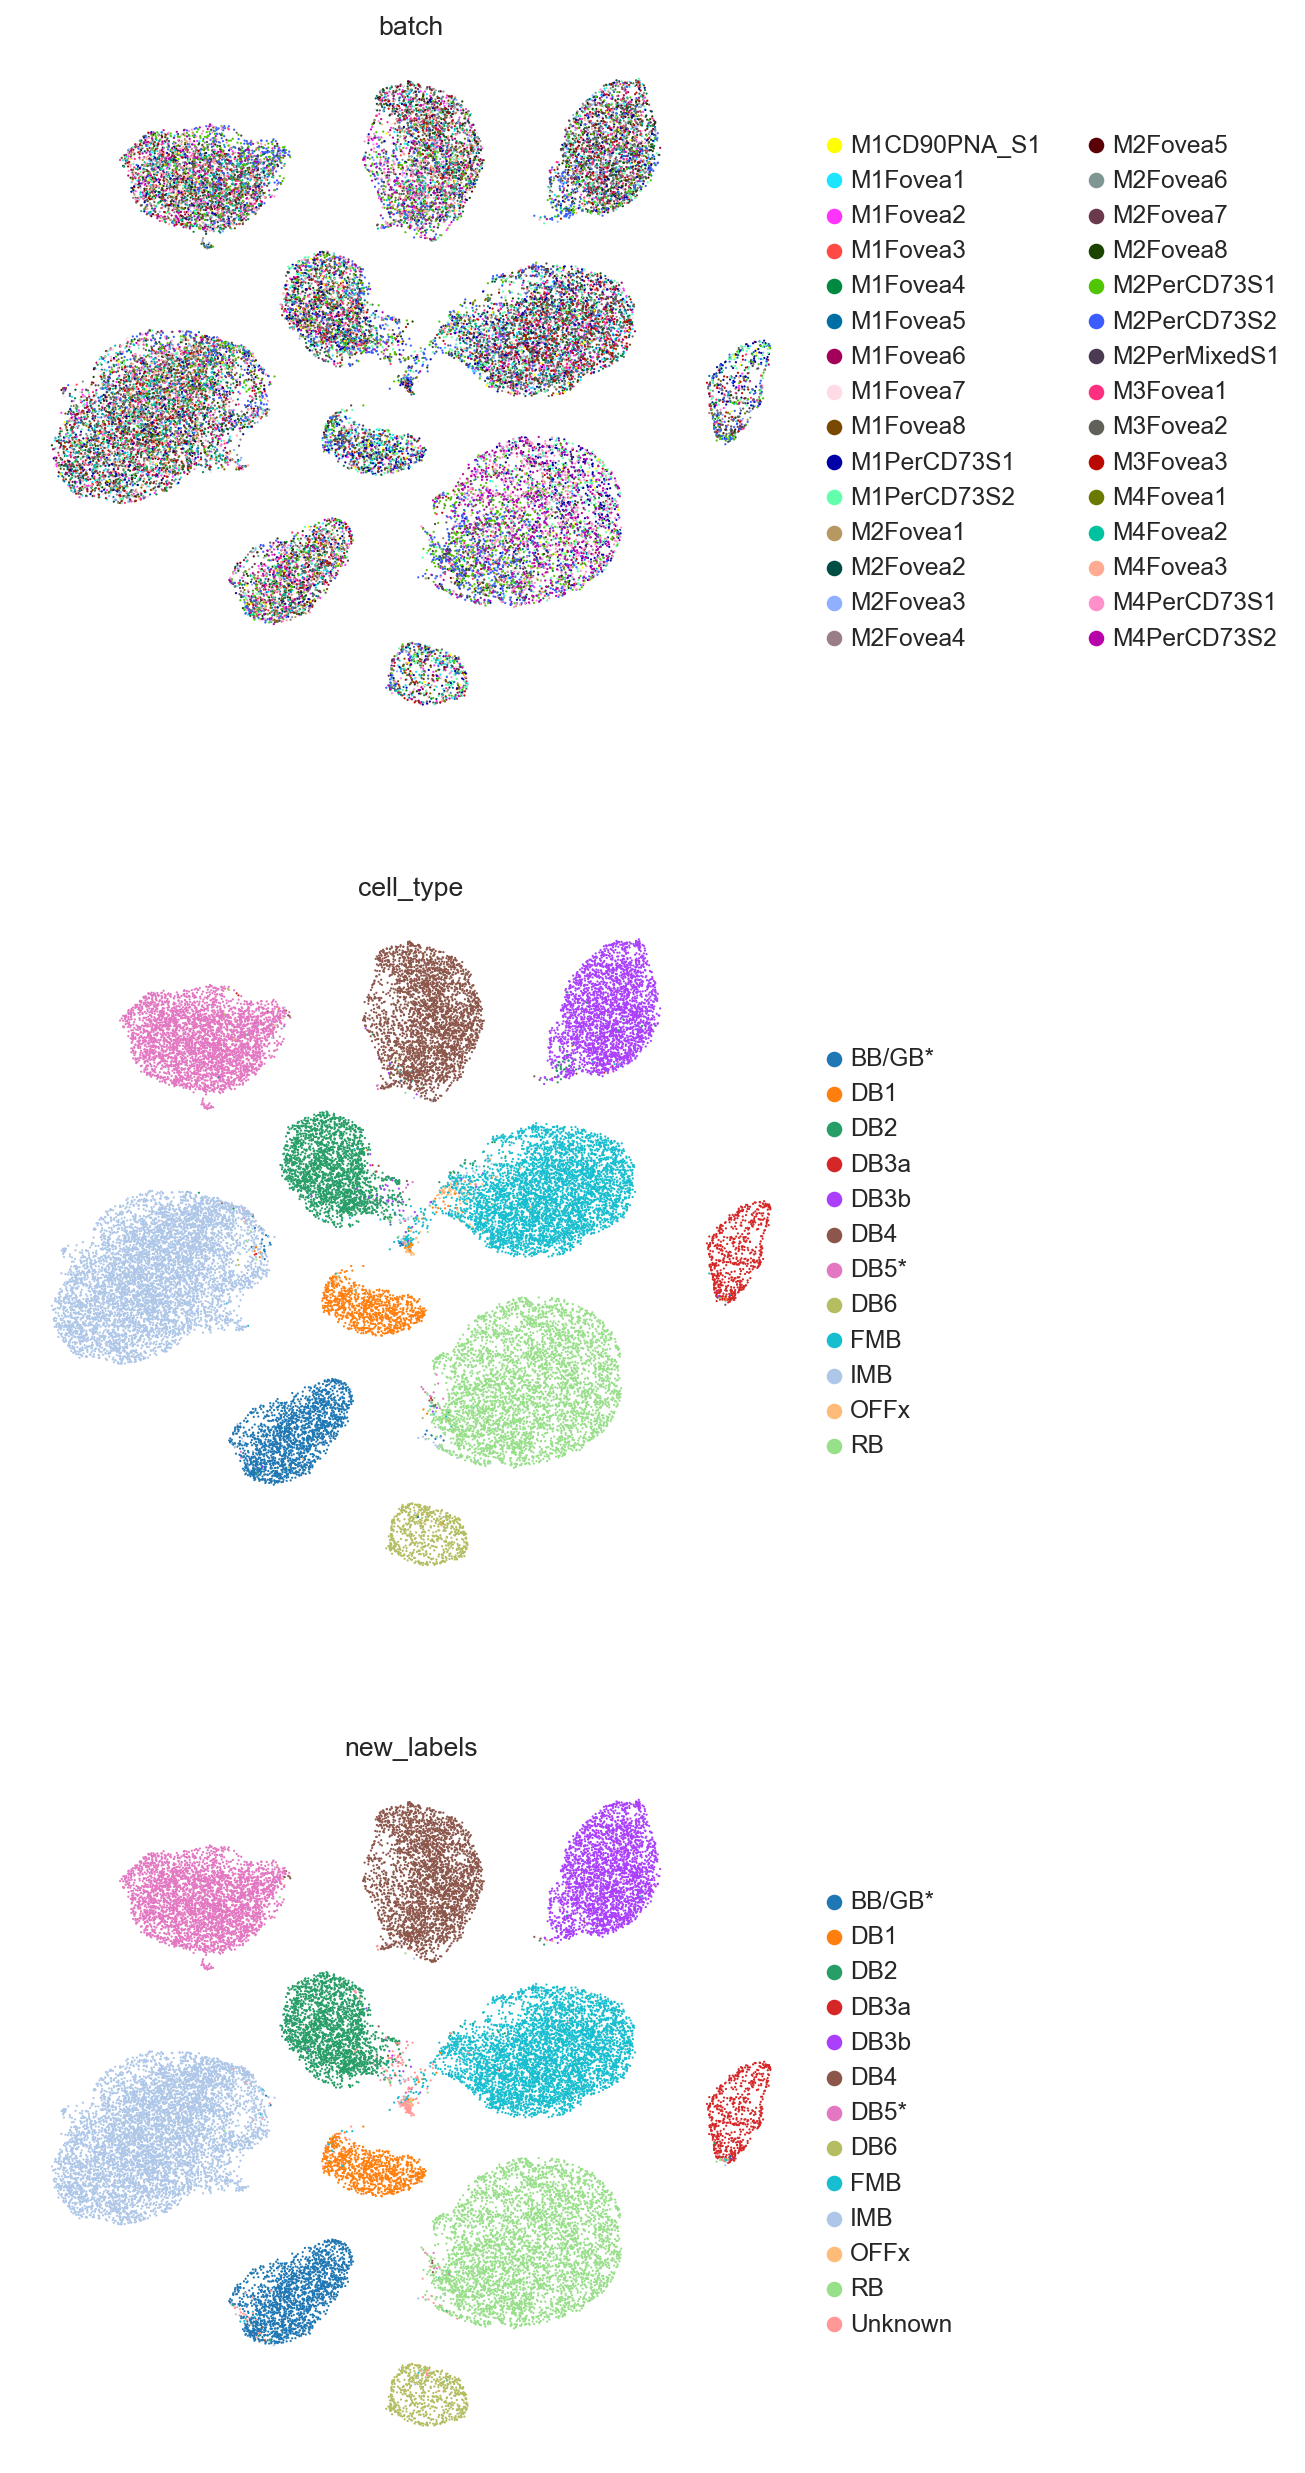

In [42]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

In [43]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/missing_and_mixing_at_edge_macaque_30.csv")

# Metric Evaluation

## read the embeddings

In [13]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/missing_and_mixing_at_edge_macaque_30.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

## Bio-conservation

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

resolution: 0.1, nmi: 0.8685828800158538
resolution: 0.2, nmi: 0.8718481099409985
resolution: 0.3, nmi: 0.8664183478651477
resolution: 0.4, nmi: 0.8568920806639039
resolution: 0.5, nmi: 0.8520461610907877
resolution: 0.6, nmi: 0.8366586642269602
resolution: 0.7, nmi: 0.8323369454733076
resolution: 0.8, nmi: 0.8277753391173521
resolution: 0.9, nmi: 0.8182531920358398
resolution: 1.0, nmi: 0.7972612934173509
resolution: 1.1, nmi: 0.7957348974275326
resolution: 1.2, nmi: 0.7890135272817048
resolution: 1.3, nmi: 0.7747752238087593
resolution: 1.4, nmi: 0.7743249164977349
resolution: 1.5, nmi: 0.7696681371058578
resolution: 1.6, nmi: 0.7650865157524863
resolution: 1.7, nmi: 0.7661123889402074
resolution: 1.8, nmi: 0.7554662679549669
resolution: 1.9, nmi: 0.7548566208262831
resolution: 2.0, nmi: 0.7461489175676299
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8718481099409985


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be remove

Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scANVI
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

cLISI score...
iLISI score...


In [ ]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.90758717089027
resolution: 0.2, nmi: 0.9334907938662613
resolution: 0.3, nmi: 0.9406675386153914
resolution: 0.4, nmi: 0.9406845012918357
resolution: 0.5, nmi: 0.9311776008919815
resolution: 0.6, nmi: 0.9248881166220791
resolution: 0.7, nmi: 0.9105420103282631
resolution: 0.8, nmi: 0.9092742091839022
resolution: 0.9, nmi: 0.9041065864450635
resolution: 1.0, nmi: 0.903018046715497
resolution: 1.1, nmi: 0.8976602411683586
resolution: 1.2, nmi: 0.8930642860128497
resolution: 1.3, nmi: 0.8902272813187294
resolution: 1.4, nmi: 0.8720709443664795
resolution: 1.5, nmi: 0.8637144712179095
resolution: 1.6, nmi: 0.8566662270700443
resolution: 1.7, nmi: 0.8521007138157309
resolution: 1.8, nmi: 0.8362523978171935
resolution: 1.9, nmi: 0.8327989327081304
resolution: 2.0, nmi: 0.8251017188437537
optimised clustering against cell_type
optimal cluster resolution: 0.4
optimal score: 0.9406845012918357


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_scgen
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

cLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP


iLISI score...


/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP
/usr/local/lib/python3.10/dist-packages/scib/metrics/lisi.py:533: RuntimeWarning: overflow encountered in divide
  P /= sumP


In [ ]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


resolution: 0.1, nmi: 0.7602205009135035
resolution: 0.2, nmi: 0.7672489058187516
resolution: 0.3, nmi: 0.7667004897435495
resolution: 0.4, nmi: 0.7718373288284767
resolution: 0.5, nmi: 0.755471803618979
resolution: 0.6, nmi: 0.754714616702934
resolution: 0.7, nmi: 0.74297113395764
resolution: 0.8, nmi: 0.7410659531061025
resolution: 0.9, nmi: 0.7209837509393857
resolution: 1.0, nmi: 0.7207767641932371
resolution: 1.1, nmi: 0.7158978405573367
resolution: 1.2, nmi: 0.7029765017190653
resolution: 1.3, nmi: 0.7094708256624359
resolution: 1.4, nmi: 0.6883685492699126
resolution: 1.5, nmi: 0.6805416107493243
resolution: 1.6, nmi: 0.6813870795997923
resolution: 1.7, nmi: 0.68511517916836
resolution: 1.8, nmi: 0.6739551236606597
resolution: 1.9, nmi: 0.6749757101521794
resolution: 2.0, nmi: 0.6685285163043106
optimised clustering against cell_type
optimal cluster resolution: 0.4
optimal score: 0.7718373288284767


/usr/local/lib/python3.10/dist-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension

Isolated labels F1...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Compute neighbors on rep X_stacas
Isolated labels ASW...


/usr/local/lib/python3.10/dist-packages/scib/metrics/isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Graph connectivity...


/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.10/dist-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/usr/local/lib/python3.1

cLISI score...
iLISI score...


In [ ]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df_cell = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df_cell

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

scANVI     scGEN    STACAS
NMI_cluster/label          0.871884  0.939329  0.770879
ARI_cluster/label          0.784975  0.900051  0.672562
ASW_label                  0.652920  0.617306  0.597939
ASW_label/batch            0.873404  0.797663  0.843112
PCR_batch                       NaN       NaN       NaN
cell_cycle_conservation         NaN       NaN       NaN
isolated_label_F1          0.973244  0.998314  0.840979
isolated_label_silhouette  0.784999  0.666358  0.626805
graph_conn                 0.997039  0.995846  0.970089
kBET                            NaN       NaN       NaN
iLISI                      0.119872  0.159230  0.162205
cLISI                      0.999675  1.000000  0.995909
hvg_overlap                     NaN       NaN       NaN
trajectory                      NaN       NaN       NaN